# Tutorial Objectives

In this tutorial, we'll implement logistic regression, a special case of GLMs used to model binary outcomes.
Oftentimes the variable you would like to predict takes only one of two possible values. Left or right? Awake or asleep? Car or bus? In this tutorial, we will decode a mouse's left/right decisions from spike train data. Our objectives are to:
1.	Learn about logistic regression, how it is derived within the GLM theory, and how it is implemented in scikit-learn
2.	Apply logistic regression to decode choies from neural responses

<br>

We would like to acknowledge [Steinmetz _et al._, 2019](https://www.nature.com/articles/s41586-019-1787-x) for sharing their data, a subset of which is used here.

We thank NMA, most of this tutorial is inspired by NMA Materials on GLM

---
# Setup

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

##  Figure settings


In [4]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Plotting Functions


In [5]:
# @title Plotting Functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze())
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()
  plt.show()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )
    plt.show()


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="C",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()


def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="C",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")
  plt.show()

##  Data retrieval and loading


In [6]:
#@title Data retrieval and loading
import os
import requests
import hashlib

url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_steinmetz_data(data_fname=fname):

  with np.load(data_fname) as dobj:
    data = dict(**dobj)

  return data

---

# Section 1: Logistic regression

Logistic Regression is a binary classification model. It is a GLM with a *logistic* link function and a *Bernoulli* (i.e. coinflip) noise model.

Like in the last notebook, logistic regression invokes a standard procedure:

1.   Define a *model* of how inputs relate to outputs.
2.   Adjust the parameters to maximize (log) probability of your data given your model

## Section 1.1: The logistic regression model


<details>
The fundamental input/output equation of logistic regression is:

\begin{equation}
\hat{y} \equiv p(y=1|x,\theta) = \sigma(\theta^\top x)
\end{equation}

Note that we interpret the output of logistic regression, $\hat{y}$, as the **probability that y = 1** given inputs $x$ and parameters $\theta$.

Here $\sigma(\cdot)$ is a "squashing" function called the **sigmoid function** or **logistic function**. Its output is in the range $0 \leq y \leq 1$. It looks like this:

\begin{equation}
\sigma(z) = \frac{1}{1 + \textrm{exp}(-z)}
\end{equation}

Recall that $z = \theta^\top x$. The parameters decide whether $\theta^\top x$ will be very negative, in which case $\sigma(\theta^\top x)\approx 0$, or very positive, meaning  $\sigma(\theta^\top x)\approx 1$.
</details>

### Coding Exercise 1.1: Implement the sigmoid function


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3c/zw43lxgs5fddpcbbxq9v1wp00000gn/T/ipykernel_24372/667084981.py:10: SyntaxWarning: invalid escape sequence '\s'
  plot_function(sigmoid, "\sigma", "z", (-10, 10))


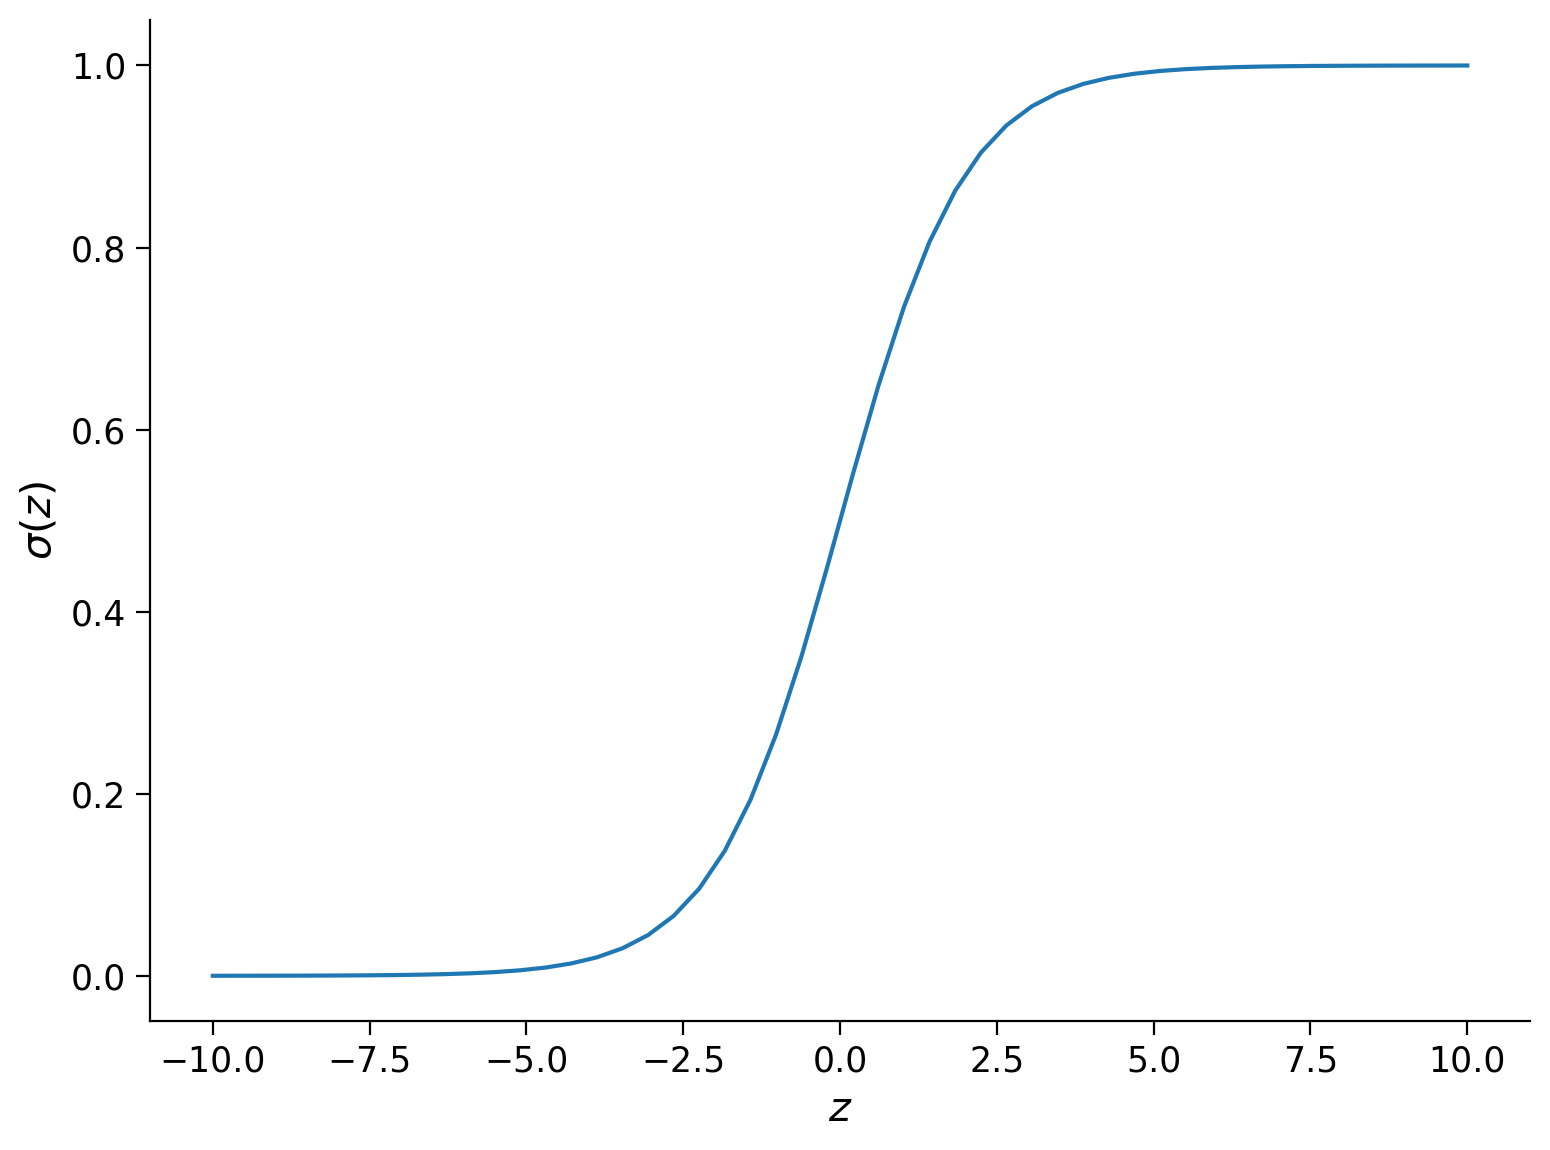

In [7]:
def sigmoid(z):
  """Return the logistic transform of z."""
  
  sigmoid = 1/(1 + np.exp(-z))

  return sigmoid


# Visualize
plot_function(sigmoid, "\sigma", "z", (-10, 10))

## Section 1.2: Using scikit-learn

Unlike the previous notebook, we're not going to write the code that implements all of the Logistic Regression model itself. Instead, we're going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/), a very popular library for Machine Learning.

The goal of this next section is to introduce `scikit-learn` classifiers and understand how to apply it to real neural data.

---
# Section 2: Decoding neural data with logistic regression

## Section 2.1: Setting up the data


In this notebook we'll use the Steinmetz dataset. This dataset includes recordings of neurons as mice perform a decision task.

Mice had the task of turning a wheel to indicate whether they perceived a Gabor stimulus to the left, to the right, or not at all. Neuropixel probes measured spikes across the cortex. Check out the following task schematic below from the BiorXiv preprint.




 Execute to see schematic


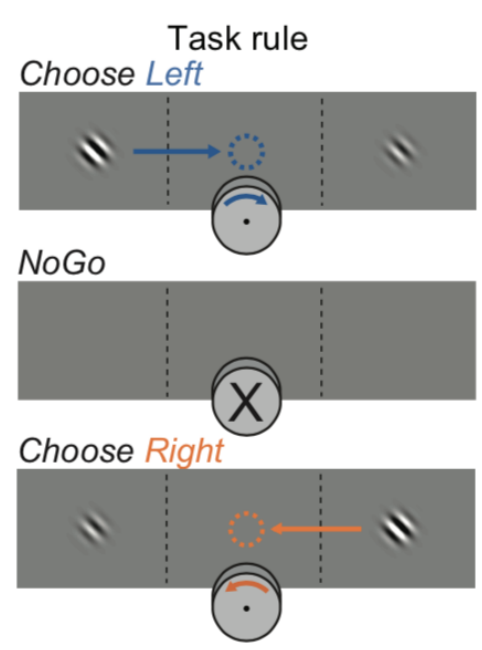

In [8]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/steinmetz-task.png")

Today we're going to **decode the decision from neural data** using Logistic Regression. We will only consider trials where the mouse chose "Left" or "Right" and ignore NoGo trials.

### Data format

In the hidden `Data retrieval and loading` cell, there is a function that loads the data:

- `spikes`: an array of normalized spike rates with shape `(n_trials, n_neurons)`
- `choices`: a vector of 0s and 1s, indicating the animal's behavioural response, with length `n_trials`.

In [9]:
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

spikes (276, 691)
choices (276,)


As with the GLM you've seen in the previous tutorial (Linear Nonlinear Poisson Model), we will need two data structures:

- an `X` matrix with shape `(n_samples, n_features)`
- a `y` vector with length `n_samples`.

In the previous notebook, `y` corresponded to the neural data, and `X` corresponded to something about the experiment. Here, we are going to invert those relationships. That's what makes this a *decoding* model: we are going to predict behaviour (`y`) from the neural responses (`X`):

In [10]:
y = data["choices"]
X = data["spikes"]

## Section 2.2: Fitting the model

Using a Logistic Regression model within `scikit-learn` is very simple.

In [11]:
# Define the model
log_reg = LogisticRegression()

# Fit it to data
log_reg.fit(X, y)

LogisticRegression()

There's two steps here:

- We *initialized* the model
- We *fit* the model by passing it the `X` and `y` objects.



## Section 2.3: Classifying the training data

Fitting the model performs maximum likelihood optimization, learning a set of *feature weights*. We can use those learned weights to *classify* new data, or predict the labels for each sample:

In [12]:
y_pred = log_reg.predict(X)

## Section 2.4: Evaluating the model

Now, we need to evaluate the predictions of the model. We will use an *accuracy* score for this purpose. The accuracy of a classifier is determined by the proportion of correct trials, where the predicted label matches the true label, out of the total number of trials.

### Coding Exercise 2.4: Classifier accuracy

For the first exercise, implement a function to evaluate a classifier using the accuracy score. Use it to get the accuracy of the classifier on the *training* data.

In [13]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """
  y_pred = model.predict(X)

  accuracy = (y_pred == y).sum()/len(y)

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 97.83%


## Section 2.5: Cross-validating the classifier


Classification accuracy on the training data is almost perfect! That might sound impressive, but the classifier may have learned something idiosyncratic about the training data. If that's the case, it won't have really learned the underlying data->decision function, and thus won't generalize well to new data.

To check this, we can evaluate the *cross-validated* accuracy.


 Execute to see schematic


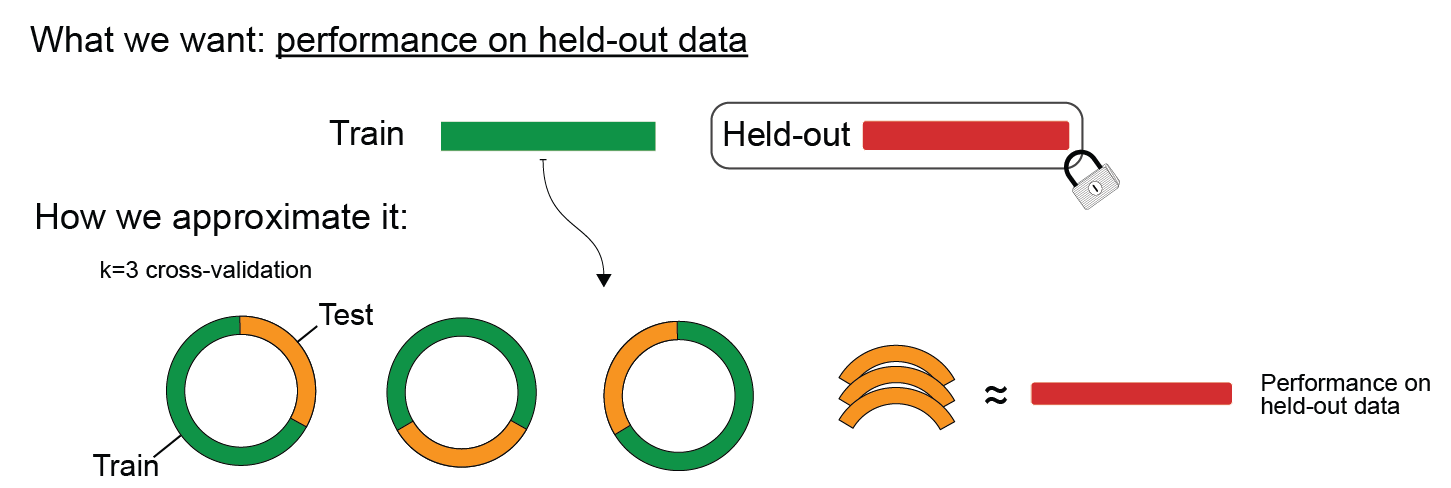

In [14]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/justCV-01.png")

### Cross-validating using `scikit-learn` helper functions

`scikit-learn` offers a number of [helpful functions](https://scikit-learn.org/stable/model_selection.html) that will do the cross-validation for you. For example, you can cross-validate a classifier using `cross_val_score`.

`cross_val_score` takes a `sklearn` model like `LogisticRegression`, as well as your `X` and `y` data. It then retrains your model on test/train splits of `X` and `y`, and returns the test accuracy on each of the test sets.

In [15]:
accuracies = cross_val_score(LogisticRegression(), X, y, cv=8)  # k=8 cross validation

 Run to plot out these `k=8` accuracy scores.


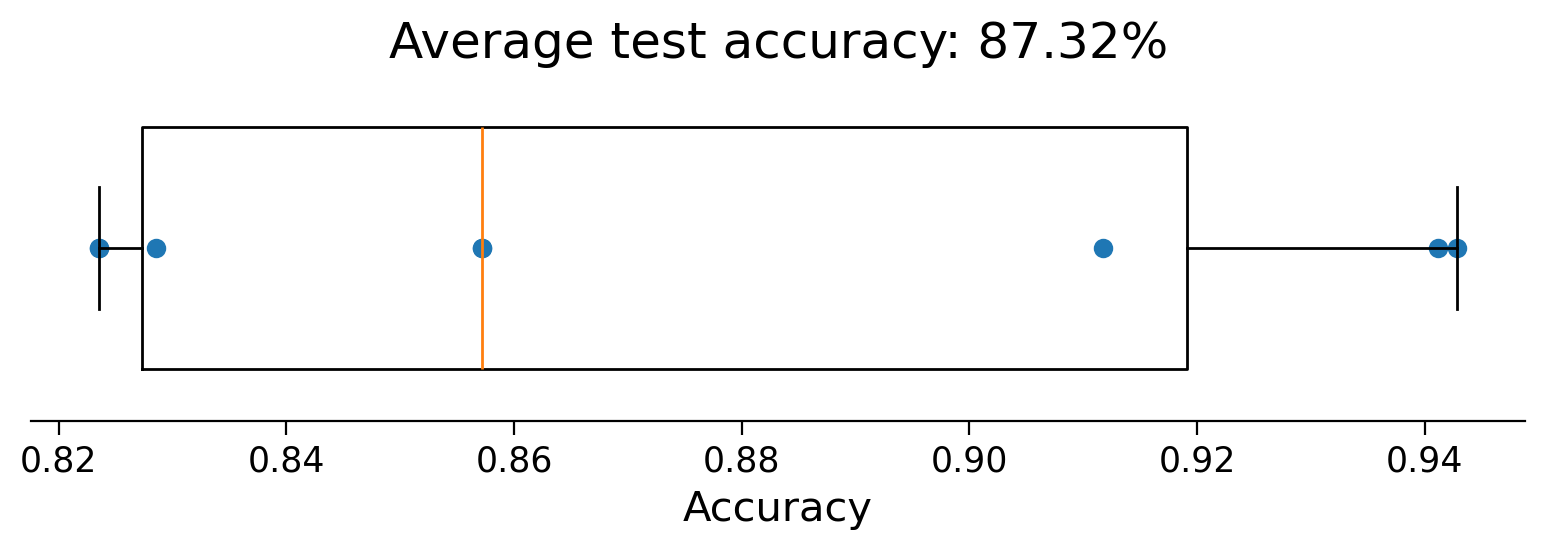

In [16]:
# @markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

We get a lower cross-validated accuracy compared to the training accuracy but it is still well above chance

The model has almost three times as many features as samples. This is a situation where overfitting is very likely (almost guaranteed).

**Link to neuroscience**: Neuro data commonly has more features than samples. Having more neurons than independent trials is one example. In fMRI data, there are commonly more measured voxels than independent trials. You should always reported cross-validated accuracy rather than accuracy on the training set


---
# Summary

In this notebook, we learned about Logistic Regression, a fundamental algorithm for *classification*. We applied the algorithm to a *neural decoding* problem: we tried to predict an animal's behavioural choice from its neural activity. 

---
# Notation

\begin{align}
x &\quad \text{input}\\
y &\quad \text{measurement, response}\\
\theta &\quad \text{parameter}\\
\sigma(z) &\quad \text{logistic function}\\
C &\quad \text{inverse regularization strength parameter}\\
\beta &\quad \text{regularization strength parameter}\\
\hat{y} &\quad \text{estimated output}\\
\mathcal{L}(\theta| y_i, x_i) &\quad \text{likelihood of that parameter } \theta \text{ producing response } y_i \text{ from input } x_i\\
L_1 &\quad \text{Lasso regularization}\\
L_2 &\quad \text{ridge regularization}\\
\end{align}